In [21]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
from tensorflow.keras.utils import load_img, img_to_array

# Verzeichnis mit unseren Trainingsdaten der Klasse 'car'
train_cars_dir = os.path.join('./data/vehicles')
test_cars_dir = os.path.join('./Test/vehicles')
validation_cars_dir = os.path.join('./Validation/vehicles')

# Verzeichnis mit unseren Trainingsdaten der Klasse 'nocar'
train_nocars_dir = os.path.join('./data/non-vehicles')
test_nocars_dir = os.path.join('./Test/non-vehicles')
validation_nocars_dir = os.path.join('./Validation/non-vehicles')



#train_cars_names = os.listdir(train_cars_dir)
#train_nocars_names = os.listdir(train_nocars_dir)

print('Anzahl Bilder im Verzeichnis Cars:', len(os.listdir(train_cars_dir)))
print('Anzahl Bilder im Verzeichnis no Cars:', len(os.listdir(train_nocars_dir)))

Anzahl Bilder im Verzeichnis Cars: 5792
Anzahl Bilder im Verzeichnis no Cars: 5968


In [22]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Zähle die Anzahl der Bilder im Trainingsverzeichnis
num_train_images = len(os.listdir(train_cars_dir)) + len(os.listdir(train_nocars_dir))

batchsize = 128
epochs = 50

# Berechne die Schritte pro Epoche
stepsperepoch = int((num_train_images / batchsize)/20)

# Bilder aus dem Trainingsdatensatz fließen in Paketen (batches) von 128 in train_datagen
train_generator = train_datagen.flow_from_directory(
        './data/',  # Quellverzeichnis für Trainingsdaten
        target_size=(64, 64),  # Alle Bilder werden auf 300x300 Pixel skaliert
        batch_size=batchsize,
        # Konfiguriere Labels für eine binäre Klassifikation
        class_mode='binary')

# Bilder aus dem Trainingsdatensatz fließen in Paketen (batches) von 128 in train_datagen
validation_generator = validation_datagen.flow_from_directory(
        './Test/',  # Quellverzeichnis für Trainingsdaten
        target_size=(64, 64),  # Alle Bilder werden auf 300x300 Pixel skaliert
        batch_size=batchsize,
        # Konfiguriere Labels für eine binäre Klassifikation
        class_mode='binary')

Found 11760 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [23]:
model = tf.keras.models.Sequential([
    # Erste Faltungsschicht
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Zweite Faltungsschicht
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Dritte Faltungsschicht
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Vierte Faltungsschicht
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten und Dense-Schicht
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    # Output layer mit einem Künstlichen Neuron, Wertebereich 0-1
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 623,265 (2.38 MB)

 Trainable params: 623,265 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(
      train_generator,
      steps_per_epoch=stepsperepoch,  
      epochs=epochs,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.5339 - loss: 0.6910 - val_accuracy: 0.8320 - val_loss: 0.6552
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.7224 - loss: 0.6393 - val_accuracy: 0.8535 - val_loss: 0.5238
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8130 - loss: 0.5025 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8663 - loss: 0.3548

2024-05-24 14:51:25.341288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.8565 - loss: 0.3716 - val_accuracy: 0.8721 - val_loss: 0.3440
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8411 - loss: 0.3655 - val_accuracy: 0.8412 - val_loss: 0.3335
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8479 - loss: 0.3440 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8194 - loss: 0.4026

2024-05-24 14:51:26.573274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.8174 - loss: 0.4060 - val_accuracy: 0.8232 - val_loss: 0.4212
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8523 - loss: 0.3349 - val_accuracy: 0.8596 - val_loss: 0.3226
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8898 - loss: 0.2834 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9484 - loss: 0.2128

2024-05-24 14:51:27.738208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9339 - loss: 0.2277 - val_accuracy: 0.8877 - val_loss: 0.2551
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9029 - loss: 0.2253 - val_accuracy: 0.9047 - val_loss: 0.2315
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8891 - loss: 0.2399 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9047 - loss: 0.1877

2024-05-24 14:51:28.879499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9090 - loss: 0.1846 - val_accuracy: 0.9258 - val_loss: 0.1764
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9633 - loss: 0.1155 - val_accuracy: 0.9457 - val_loss: 0.1324
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9615 - loss: 0.1280 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 16/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9180 - loss: 0.2028

2024-05-24 14:51:30.049260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9172 - loss: 0.2038 - val_accuracy: 0.9375 - val_loss: 0.1585
Epoch 17/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9362 - loss: 0.1856 - val_accuracy: 0.9365 - val_loss: 0.1555
Epoch 18/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9622 - loss: 0.1142 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9588 - loss: 0.1322

2024-05-24 14:51:31.187420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.9557 - loss: 0.1338 - val_accuracy: 0.9512 - val_loss: 0.1241
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9456 - loss: 0.1203 - val_accuracy: 0.9641 - val_loss: 0.1115
Epoch 21/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9674 - loss: 0.0897 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 22/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9722 - loss: 0.0771

2024-05-24 14:51:32.406890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9708 - loss: 0.0799 - val_accuracy: 0.9727 - val_loss: 0.0901
Epoch 23/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9474 - loss: 0.1271 - val_accuracy: 0.9662 - val_loss: 0.1071
Epoch 24/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 25/50


2024-05-24 14:51:33.317418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-24 14:51:33.321145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9622 - loss: 0.0895 - val_accuracy: 0.9346 - val_loss: 0.1476
Epoch 26/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9810 - loss: 0.0694 - val_accuracy: 0.9395 - val_loss: 0.1573
Epoch 27/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9529 - loss: 0.1043 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 28/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9813 - loss: 0.0523

2024-05-24 14:51:34.765009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9794 - loss: 0.0554 - val_accuracy: 0.9707 - val_loss: 0.0817
Epoch 29/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9747 - loss: 0.0809 - val_accuracy: 0.9406 - val_loss: 0.1890
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9167 - loss: 0.1790 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 31/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9688 - loss: 0.0886

2024-05-24 14:51:35.909701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.9688 - loss: 0.0900 - val_accuracy: 0.9404 - val_loss: 0.1613
Epoch 32/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9396 - loss: 0.1358 - val_accuracy: 0.9467 - val_loss: 0.1295
Epoch 33/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9656 - loss: 0.0965 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 34/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9709 - loss: 0.0945

2024-05-24 14:51:37.044583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9708 - loss: 0.0945 - val_accuracy: 0.9385 - val_loss: 0.1669
Epoch 35/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9620 - loss: 0.0997 - val_accuracy: 0.9580 - val_loss: 0.1150
Epoch 36/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9763 - loss: 0.0793 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 37/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9676 - loss: 0.0859

2024-05-24 14:51:38.157830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.9709 - loss: 0.0836 - val_accuracy: 0.9697 - val_loss: 0.0855
Epoch 38/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9794 - loss: 0.0537 - val_accuracy: 0.9764 - val_loss: 0.0639
Epoch 39/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9893 - loss: 0.0319 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 40/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9891 - loss: 0.0270

2024-05-24 14:51:39.420386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9857 - loss: 0.0327 - val_accuracy: 0.9746 - val_loss: 0.0647
Epoch 41/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9823 - loss: 0.0449 - val_accuracy: 0.9723 - val_loss: 0.0860
Epoch 42/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9872 - loss: 0.0417 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 43/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9826 - loss: 0.0349

2024-05-24 14:51:40.568027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9841 - loss: 0.0345 - val_accuracy: 0.9775 - val_loss: 0.0550
Epoch 44/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9849 - loss: 0.0446 - val_accuracy: 0.9857 - val_loss: 0.0454
Epoch 45/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9909 - loss: 0.0201 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 46/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9891 - loss: 0.0649

2024-05-24 14:51:41.687946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.9865 - loss: 0.0647 - val_accuracy: 0.9805 - val_loss: 0.0634
Epoch 47/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9966 - loss: 0.0237 - val_accuracy: 0.9805 - val_loss: 0.0568
Epoch 48/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 49/50


2024-05-24 14:51:42.625292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-24 14:51:42.627900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9812 - loss: 0.0639 - val_accuracy: 0.9766 - val_loss: 0.0571
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9786 - loss: 0.0675 - val_accuracy: 0.9785 - val_loss: 0.0634


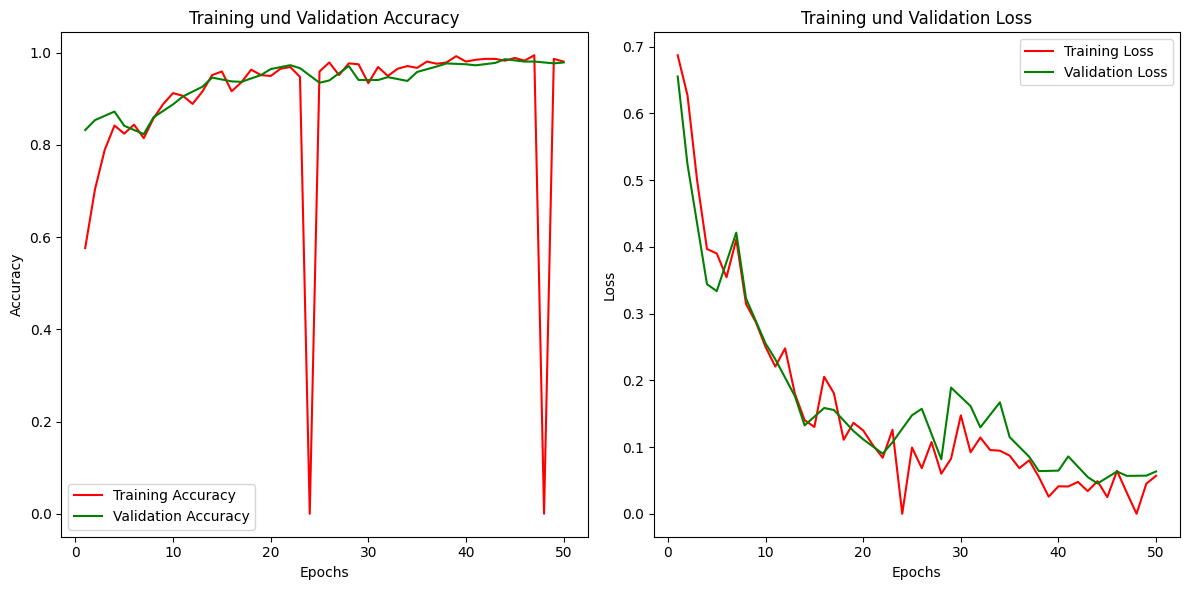

In [25]:
# Zugriff auf die Metriken aus dem history-Objekt
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

for i in range(len(val_accuracy)):
    if val_accuracy[i] < 0.01:
        val_accuracy[i] = (val_accuracy[i-1]+val_accuracy[i+1])/2

    if val_loss[i] < 10**-3:
        val_loss[i] = (val_loss[i-1]+val_loss[i+1])/2


# Zugriff auf die Anzahl der Epochen
epochs = range(1, len(train_accuracy) + 1)
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
plt.title('Training und Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training und Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [26]:
# Verzeichnis mit den Testdaten
test_dir = './Test/'

# ImageDataGenerator für Testdaten
test_datagen = ImageDataGenerator(rescale=1/255)

# Generator für Testdaten
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=batchsize,
    class_mode='binary'
)

# Modell laden
#model = tf.keras.models.load_model('dein_model.h5')

# Modell auf Testdaten evaluieren
eval_result = model.evaluate(test_generator)

# Ausgabe von Genauigkeit und Verlust
print("Test Genauigkeit:", eval_result[1])
print("Test Verlust:", eval_result[0])


Found 2000 images belonging to 2 classes.
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9779 - loss: 0.0595
Test Genauigkeit: 0.9800000190734863
Test Verlust: 0.05810394138097763
